In [1]:
import os
import re
import json
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import random
import pybullet as p
import pybullet_data
import trimesh
from collections import defaultdict, Counter

# Create Object Files

In [ ]:
from core.sim.utils import create_urdf
import shutil

def clear_files():
    for object_name in os.listdir("objects"):
        if object_name in ['sphere']:
            continue

        object_path = os.path.join("objects", object_name)
        for object_id in os.listdir(object_path):
            object_id_path = os.path.join(object_path, object_id)

            for f_name in os.listdir(object_id_path):
                f_path = os.path.join(object_id_path, f_name)

                # Remove 'assets' directory if it exists
                if f_name == "assets" and os.path.isdir(f_path):
                    try:
                        shutil.rmtree(f_path)
                        print(f"Removed directory: {f_path}")
                    except Exception as e:
                        print(f"Error removing directory {f_path}: {e}")
                    continue  # Skip further checks for this item

                # Check if it is a file (not a directory)
                if os.path.isfile(f_path):
                    # Keep only files ending with .glb or .blend
                    if not (f_name.endswith('.glb') or f_name.endswith('.blend')):
                        try:
                            os.remove(f_path)
                            print(f"Removed file: {f_path}")
                        except Exception as e:
                            print(f"Error deleting {f_path}: {e}")

object_specs = [
    ('table', 0.5, False),
    ('knife', 0.04, False),
    ('spoon', 0.04, False),
    ('fork', 0.04, False),
    ('apple', 0.2, False),
    ('banana', 0.2, False),
    ('pear', 0.2, False),
    ('mug', 0.5, True),
    ('paper-cup', 0.3, True),
    ('bowl', 0.4, True),
    ('box', 0.3, True),
    ('basket', 0.3, True),
    ('pan', 0.7, True)
]

# clear_files()

# for name, mass, convex in object_specs:
#     create_urdf(name, mass, convex)


# Create Meta File

In [ ]:
from core.env.scene_manager import OBJECTS

def get_object_diameter(obj_name, body_type, object_dir="core/sim/objects"):
    mesh_path = f"{object_dir}/{obj_name}/{obj_name}_{body_type}/{obj_name}_{body_type}.obj"
    mesh = trimesh.load_mesh(mesh_path)
    extents = mesh.bounding_box.extents
    diameter = np.max(extents[:2])  # XY-plane diameter
    if obj_name in ['basket', 'box']:
        diameter = (diameter + np.linalg.norm(extents[:2])) / 2
    return diameter

def compute_max_diameters(object_dir="core/sim/objects"):
    p.connect(p.DIRECT)
    max_diameters = {}

    object_names = [d for d in os.listdir(object_dir) if os.path.isdir(os.path.join(object_dir, d))]

    for name in object_names:
        try:
            body_types = [
                int(folder.split("_")[-1])
                for folder in os.listdir(f"{object_dir}/{name}")
                if folder.startswith(f"{name}_")
            ]
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

        diameters = []
        for body_type in sorted(body_types):
            try:
                diameter = get_object_diameter(name, body_type, object_dir)
                diameters.append(diameter)
            except Exception as e:
                print(f"Failed to process {name} bodyType {body_type}: {e}")
        if diameters:
            max_diameters[name] = np.round(max(diameters), 2)

    p.disconnect()
    return max_diameters

# Update sizes in OBJECTS
max_diameters = compute_max_diameters()
for obj in OBJECTS.values():
	name = obj["name"]
	if name in max_diameters:
		size = np.round(max_diameters[name] * 100)
		if size % 2 == 0:
			size += 1
		obj["size"] = (size, size)

object_sizes = {k: v["size"] for k, v in OBJECTS.items()}
object_sizes

In [ ]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import create_scene_meta, save_scene_meta, get_next_scene_id

def save_rearrangement_meta(dataset_dir, grid_size, initial_x, target_x, scene_id):
	subfolder_name = f'rearrangement_{scene_id:05d}'
	subfolder_path = os.path.join(dataset_dir, subfolder_name)
	
	# Use shared utility functions
	scene_meta = create_scene_meta(initial_x, target_x, scene_id, grid_size)
	meta_path = os.path.join(subfolder_path, 'meta.json')
	save_scene_meta(scene_meta, meta_path, verbose=True)

# --- Main execution ---
num_cases = 10
grid_size = (100, 100)
dataset_dir = 'temp'

# Get starting scene ID
scene_id = get_next_scene_id(dataset_dir, prefix='rearrangement')
if scene_id == 0:
	scene_id += 1

for num_objects in [3, 4]:
	print(f'Generating {num_cases} scenes with {num_objects} objects...')
	
	# Create environment with custom object sizes
	env = SceneManager(
		num_objects=num_objects,
		grid_size=grid_size,
		verbose=0
	)
	
	# Override with the computed object sizes
	env.object_sizes = object_sizes
	
	for _ in range(num_cases):
		# Generate scene using SceneManager
		env.reset(use_stack=True, use_sides=False)
		
		initial_x = env.initial_x.clone()
		target_x = env.target_x.clone()
		
		save_rearrangement_meta(dataset_dir, grid_size, initial_x, target_x, scene_id)
		scene_id += 1


# Simulation

Loading random rearrangement: rearrangement_00003
Loading specific rearrangement: rearrangement_00003
Scene ID: 3
Number of objects: 3
Grid size: [100, 100]
Using default object sizes
Manipulator at [49, 49]


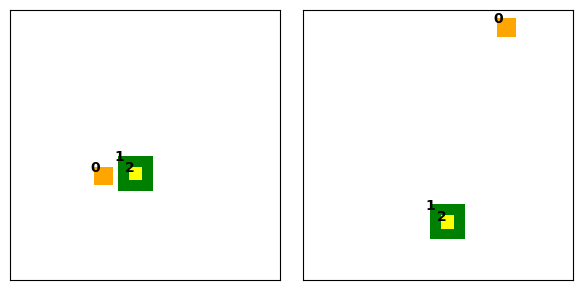

Loading specific rearrangement: rearrangement_00003


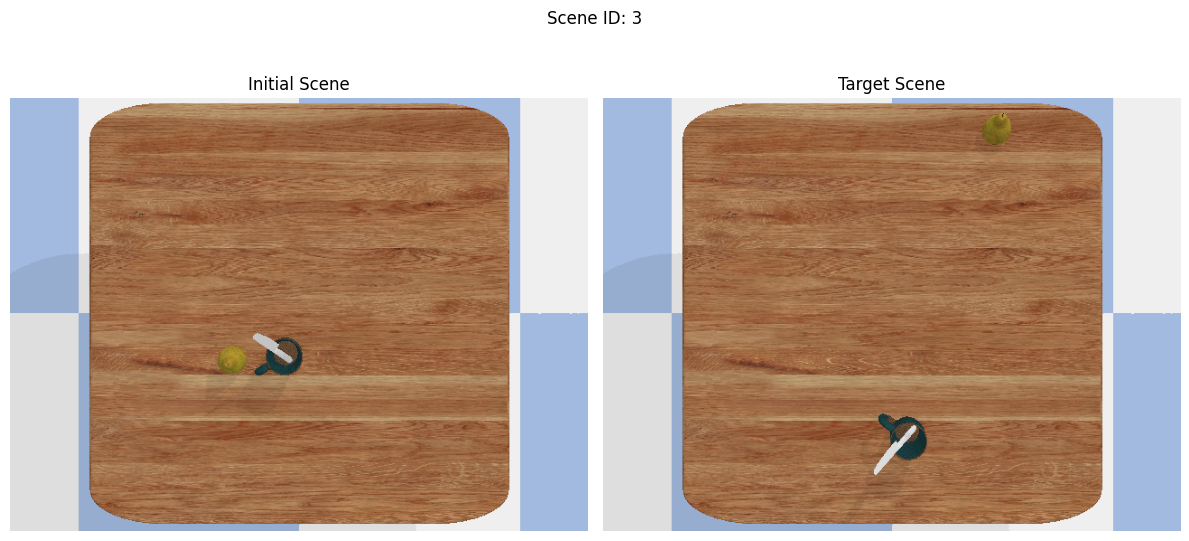

In [ ]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import scene_meta_to_x
from core.sim.utils import select_rearrangement_dir, load_rearrangement_meta, visualize_rearrangement

dataset_dir = "temp"
scene_id = select_rearrangement_dir(dataset_dir)[1]
meta_data = load_rearrangement_meta(dataset_dir, scene_id=scene_id)

print(f"Scene ID: {meta_data.get('scene_id', 'Unknown')}")
print(f"Number of objects: {meta_data.get('num_objects', 'Unknown')}")
print(f"Grid size: {meta_data.get('grid_size', 'Unknown')}")

initial_x, target_x = scene_meta_to_x(meta_data)
env = SceneManager(
    num_objects=meta_data['num_objects'],
    grid_size=tuple(meta_data['grid_size'])
)
env.reset(initial_scene=initial_x, target_scene=target_x)
env.render(fig_size=3)
visualize_rearrangement(dataset_dir, scene_id=scene_id)

In [ ]:
from core.env.scene_manager import OBJECTS
from core.sim.utils import (
	Camera, PyBulletSim, load_object_urdf, load_table_urdf, get_bounding_box_size, random_tilt
)

def compute_position_and_orientation(obj, objects, base_z):
	stack_hierarchy = 0
	j = obj['base_id']
	while j is not None:
		stack_hierarchy += 1
		j = objects[j]['base_id']

	pos = [obj['pos'][0], obj['pos'][1], base_z + 0.05 + 0.085 * stack_hierarchy]
	orn = [0, 0, 0]

	if stack_hierarchy > 0 and obj['label'] in [0, 1, 2]:
		orn[0] = np.pi / 2
		j = obj['base_id']
		if objects[j]['label'] in [6, 7]:
			pos, orn = random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
		elif objects[j]['label'] == 8:
			pos, orn = random_tilt(pos, orn, max_shift=0.02, shift_end=True, tilt_angle=10)
		else:
			orn[2] = random.uniform(0, 2 * np.pi)
	else:
		orn[2] = random.uniform(0, 2 * np.pi)

	return pos, orn

def map_position(pos, x_range, y_range, grid_scale=0.01):
	x, y = pos

	# Map x
	new_x_min, new_x_max = x_range
	new_x = x * grid_scale * (new_x_max - new_x_min) + new_x_min

	# Map y
	new_y_min, new_y_max = y_range
	new_y = y * grid_scale * (new_y_max - new_y_min) + new_y_min

	return new_x, new_y

def get_available_body_types(objects):
    available = {}
    for obj in objects:
        model_name = obj['model_name']
        if model_name not in available:
            available[model_name] = len(os.listdir(f"core/sim/objects/{model_name}"))
    return available

def choose_least_used_body_type(model_name, available_body_types, counter):
    count = counter[model_name]
    num_types = available_body_types[model_name]
    min_used = min(count.get(bt, 0) for bt in range(1, num_types + 1))
    candidates = [bt for bt in range(1, num_types + 1) if count.get(bt, 0) == min_used]
    chosen = random.choice(candidates)
    counter[model_name][chosen] += 1
    return chosen

def create_objects_with_new_body_types(scene_meta, mode, x_range, y_range, z, fixed_body_types=None):
    """
    Create objects with newly assigned body types (for generating new labels).
    This is the original function renamed for better clarity.
    """
    objects = []
    for i, obj in enumerate(scene_meta['objects']):
        label = int(obj['label'])
        model_name = OBJECTS[label]['name']
        position = obj['initial_pos'] if mode == "initial" else obj['target_pos']
        base_id = obj['initial_base_id'] if mode == "initial" else obj['target_base_id']

        objects.append({
            'object_id': i,
            'label': label,
            'model_name': model_name,
            'pos': map_position(position, x_range, y_range),
            'base_id': base_id,
        })

    available_body_types = get_available_body_types(objects)
    body_type_counter = defaultdict(Counter)

    for obj in objects:
        model_name = obj['model_name']
        pos, orn = compute_position_and_orientation(obj, objects, z)

        if fixed_body_types:
            chosen_type = fixed_body_types[obj['object_id']]
        else:
            chosen_type = choose_least_used_body_type(model_name, available_body_types, body_type_counter)

        body_id, _ = load_object_urdf(model_name, pos, orn, body_type=chosen_type)
        obj['body_id'] = body_id
        obj['body_type'] = chosen_type

    return objects

# sim = PyBulletSim(p.DIRECT)
# table = load_table_urdf((100, 100))
# z = get_bounding_box_size(table)[2]
# # cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.2, yaw=90, pitch=-50, roll=0)
# cam = Camera(target_pos=[0, 0, 1.5], distance=0.2, yaw=90, pitch=-90, roll=0)
# x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]
# objects = create_objects_with_new_body_types(meta_data, "initial", x_range, y_range, z)

# sim.step(5)

# # bboxes, labels = [], []
# # for obj in objects:
# # 	bboxes.append(cam.compute_bounding_box(obj['model_name'], obj['body_id'], obj['body_type']))
# # 	labels.append(f"{obj['model_name']}_{obj['body_id']}")
# # cam.draw_bounding_boxes(cam.capture_image(), bboxes, labels)
# cam.show_img(cam.capture_image())

# sim.close()

In [ ]:
def generate_image_and_label(meta_data, folder_path, mode):
	assert mode in ('initial', 'target')

	image_path = os.path.join(folder_path, f'{mode}_image.png')
	label_path = os.path.join(folder_path, f'{mode}_labels.json')

	sim = PyBulletSim(p.DIRECT)
	table = load_table_urdf((100, 100))
	z = get_bounding_box_size(table)[2]
	# cam = Camera(target_pos=[0.6, 0, 1.3], distance=0.2, yaw=90, pitch=-50, roll=0)
	cam = Camera(target_pos=[0, 0, 1.5], distance=0.2, yaw=90, pitch=-90, roll=0)
	x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]

	fixed_body_types = None
	if mode == 'target':
		initial_labels_path = os.path.join(folder_path, 'initial_labels.json')
		with open(initial_labels_path, 'r') as f:
			initial_labels = json.load(f)
		fixed_body_types = {
			obj['obj_id']: int(obj['model_id'].split('_')[-1])
			for obj in initial_labels
		}

	objects = create_objects_with_new_body_types(meta_data, mode, x_range, y_range, z, fixed_body_types)

	sim.step(5)

	json_data = []
	for obj in objects:
		bbox = cam.compute_bounding_box(obj['model_name'], obj['body_id'], obj['body_type'], num_samples=500)
		pos, orn = p.getBasePositionAndOrientation(obj['body_id'])
		euler = p.getEulerFromQuaternion(orn)
		json_data.append({
			"model_name": obj['model_name'],
			"model_id": f"{obj['model_name']}_{obj['body_type']}",
			"obj_id": int(obj['object_id']),
			"6D_pose": [float(x) for x in (pos + euler)],
			"natural_parent_list": [int(obj['base_id'])] if obj['base_id'] is not None else [],
			"bbox": [float(x) for x in bbox],
		})

	with open(label_path, 'w') as f:
		json.dump(json_data, f, indent=4)

	image = cam.capture_image()
	# cam.show_img(image)
	img = Image.fromarray(image)
	img.save(image_path)

	sim.close()

dataset_dir = 'temp'
rearrangements = sorted([
    d for d in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, d)) and d.startswith('rearrangement_')
])

print(f'Found {len(rearrangements)} rearrangement folders.')

pbar = tqdm(rearrangements, desc="Processing rearrangements")

for folder_name in pbar:
    folder_path = os.path.join(dataset_dir, folder_name)
    meta_path = os.path.join(folder_path, 'meta.json')

    if not os.path.exists(meta_path):
        pbar.set_description(f'Skipping {folder_name}: no meta')
        continue

    with open(meta_path, 'r') as f:
        meta_data = json.load(f)

    initial_image_path = os.path.join(folder_path, 'initial_image.png')
    target_image_path = os.path.join(folder_path, 'target_image.png')

    if not os.path.exists(initial_image_path):
        pbar.set_description(f'{folder_name}: Generating initial')
        generate_image_and_label(meta_data, folder_path, mode='initial')

    if not os.path.exists(target_image_path):
        pbar.set_description(f'{folder_name}: Generating target')
        generate_image_and_label(meta_data, folder_path, mode='target')

    # Reset to default after each iteration
    pbar.set_description("Processing rearrangements")
